# name: Marco Giunta
## Rlab05

In [1]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# Exercise 1: newspaper inference
**Introduction**
In order to apply Bayes' theorem to this problem we first need to setup a generative model for the data. Notice that each person either reads the journal or doesn't; if we suppose that for any given person the former happens with probability $p$ then this process can be modelled as a Bernoulli trial.

**a)** Due to the above if we sample a population of multiple people the process as a whole can be modelled with a *binomial* distribution - parametrized by an unknown value of $p$.   

**b)** Bayes' theorem states that:
\begin{equation}
  \text{posterior} = \frac{\text{likelihood}\times\text{prior}}{\text{evidence}}
\end{equation}
The denominator is just a constant normalization factor; if we assume a uniform prior then the prior itself equals a constant, too. This means that in our case
\begin{equation}
  \text{posterior} \propto \text{likelihood}
\end{equation}
i.e. the posterior and the likelihood are the same function up to a change of scale needed to normalize the area.       

**c)** The above points imply that the likelihood is $\text{Binom}(k = 29, n = 150; p)$ - where $n$ and $k$ are fixed by the data, whereas $p$ is the only true (continuous) variable and target of the inference. Of course $p \in [0,1]$; hence to normalize the likelihood wrt $p$ we need to integrate over $I=[0,1]$ i.e.
\begin{equation}
  \text{posterior} = \frac{\text{Binom}(k=29,n=150;p)}{\int_0^1 \text{Binom}(k=29,n=150;p)\mathrm{d}p}
\end{equation}

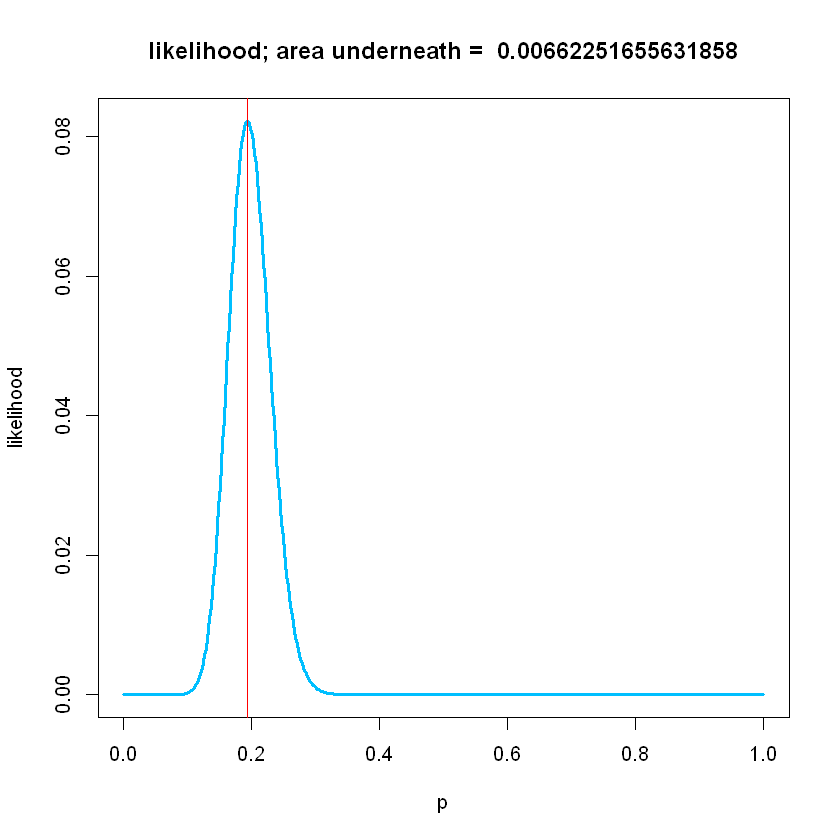

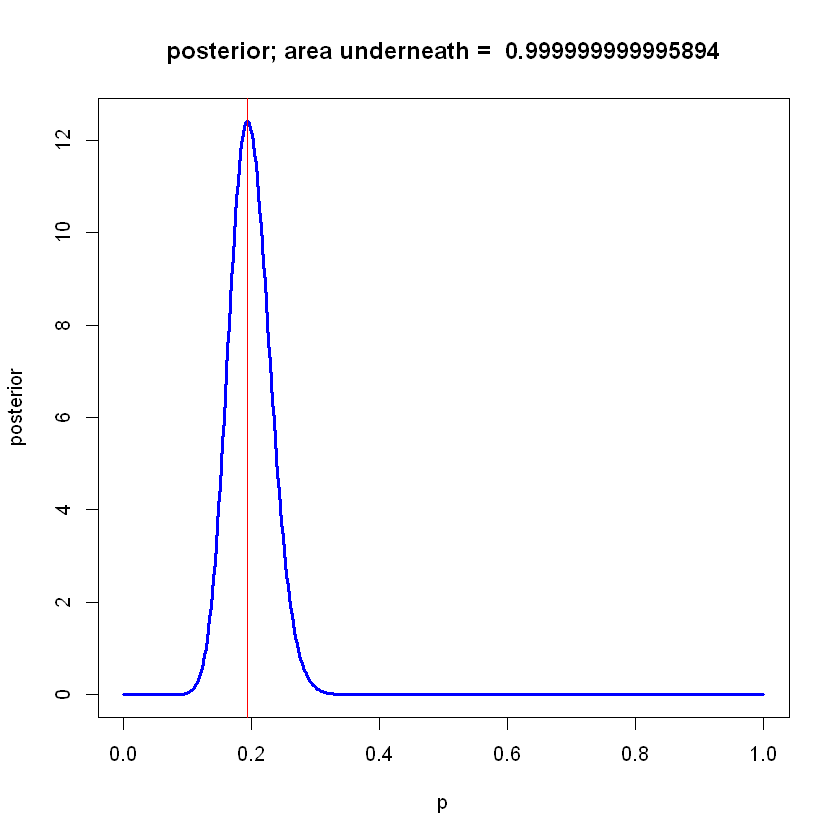

In [2]:
likelihood <- function(p) dbinom(x = 29, size = 150, prob = p) # explicit but equivalent function definition: function(p) p^29*(1-p)^(150-29) * choose(150,29)

posterior <- function(p) likelihood(p)/integrate(likelihood, lower = 0, upper = 1)$value

p.vector <- seq(0, 1, length.out = 500)

plot(p.vector, likelihood(p.vector), type = "l", lwd = 3, col = "deepskyblue", xlab = "p", ylab = "likelihood", main = paste("likelihood; area underneath = ",integrate(likelihood, 0, 1)$value))
abline(v = 29/150, col = "red")
#lines(p.vector, posterior(p.vector), lwd = 3, col = "blue")
plot(p.vector, posterior(p.vector), type = "l", lwd = 3, col = "blue", xlab = "p", ylab = "posterior", main = paste("posterior; area underneath = ", integrate(posterior, 0, 1)$value))
abline(v = 29/150, col = "red")

Notice that the mode is exactly at $29/150$. This makes sense: in absence of any pre-existing information (we picked a uniform prior) our best "intuitive" estimate for $p$ coming from the data should be $29/150$.

# Exercise 2: concert hall inference
Exactly as in exercise 1 we can model this process with a binomial likelihood: each person either likes or dislikes the new concert hall, and we can assume any randomly chosen citizen does with an unknown prob. $p$.
## Ex. 2.1: priors comparison
Plotting uniform and trapezoidal priors is trivial; we only need some care handling the beta distribution, which is best to reparametrize.         
[It's possible to show](https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance) that the $\alpha$ and $\beta$ parameters of a beta distribution with mean $\mu$ and variance $\sigma^2$ are:
\begin{equation}
  \alpha = \mu \left(\frac{\mu(1-\mu)}{\sigma^2}-1\right)
\end{equation}
\begin{equation}
  \beta = \left(\frac{1}{\mu}-1\right) \left(\frac{\mu(1-\mu)}{\sigma^2}-1\right) = \left(\frac{1}{\mu}-1\right)\alpha
\end{equation}
We can use these equations to compute the `shape1` and `shape2` arguments of base R's `dbeta` function.

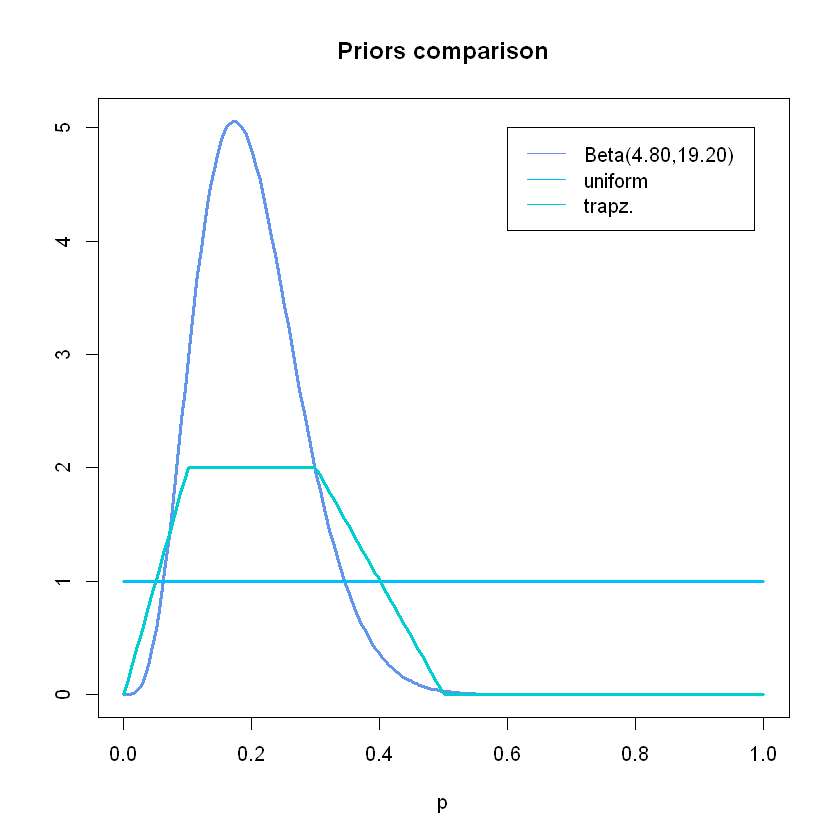

In [3]:
mu <- 0.2; sd <- 0.08

alpha <- mu*(mu*(1-mu)/sd^2-1)
beta  <- (1/mu-1)*mu*(mu*(1-mu)/sd^2-1) 

beta.prior <- function(p) dbeta(p, shape1 = alpha, shape2 = beta)
uniform.prior <- function(p) rep(1, times = length(p)) # Notice that f(p)=1 defined over [0,1] is already normalized --> no normaliz. factor is needed
trapezoidal.prior <- function(p) ifelse(0 <= p & p < 0.1, 20*p, ifelse(0.1 <= p & p < 0.3, 2, ifelse(0.3 <= p & p < 0.5, 5-10*p, 0)))

p.vector <- seq(0,1, length.out = 200) # p is in [0,1], of course
plot(p.vector, beta.prior(p.vector), type = "l", col = "cornflowerblue", lwd = 3, xlab = "p", ylab = "", main = "Priors comparison")
lines(p.vector, uniform.prior(p.vector), col = "deepskyblue", lwd = 3)
lines(p.vector, trapezoidal.prior(p.vector), col = "darkturquoise", lwd = 3)
legend(legend = c(sprintf("Beta(%.2f,%.2f)",alpha,beta),"uniform","trapz."), col = c("cornflowerblue","deepskyblue","darkturquoise"), lty = rep(1, times = 3), x = 0.6, y = 5)

## Ex. 2.2: posterior inference
Here we apply Bayes' theorem exactly like in ex. 1; we also have the same binomial likelihood (but with $r/n = 26/100$, this time). Once we have evaluated the posteriors we can a) plot them, and b) numerically find their max. by evaluating them over a discrete set of values.

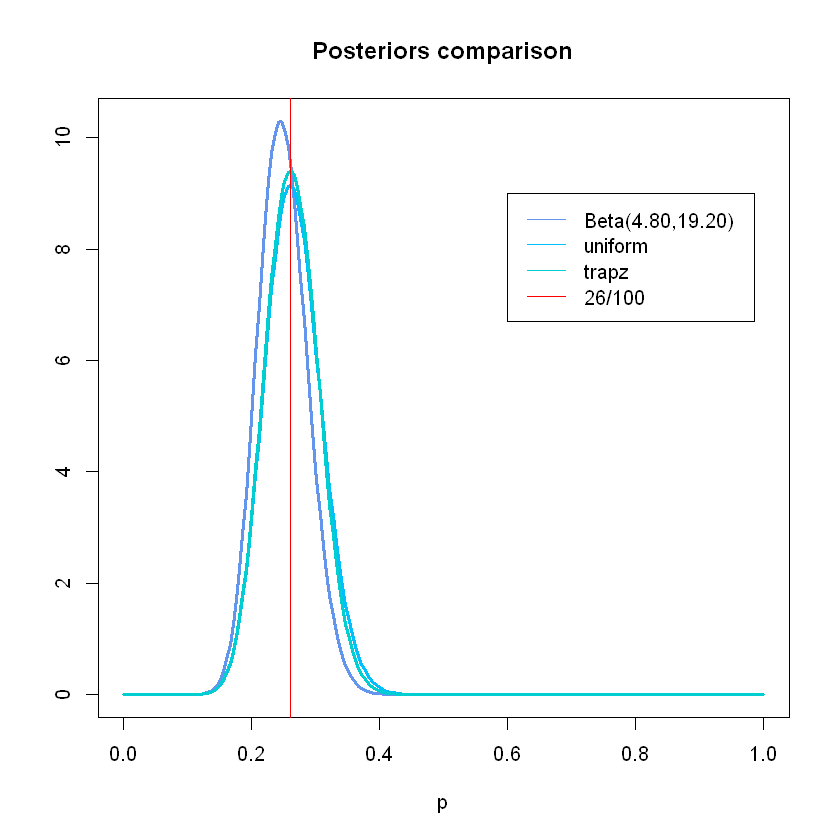

In [4]:
# We encapsulate Bayes' theorem in its most general form valid for continuous distributions as follows:
compute.posterior <- function(likelihood, prior) {
    numerator <- function(p) likelihood(p)*prior(p) # numerator in the RHS of the B.T. = a function of the unknown value of p
    denominator <- integrate(numerator, 0, 1)$value # RHS denominator = a constant normalization factor
    posterior <- function(p) numerator(p)/denominator
    return (posterior)
}
# POSTERIORS EVALUATION
binom.likelihood            <- function(p) dbinom(prob = p, x = 26, size = 100)
posterior.beta.prior        <- compute.posterior(likelihood = binom.likelihood, prior = beta.prior)
posterior.uniform.prior     <- compute.posterior(likelihood = binom.likelihood, prior = uniform.prior)
posterior.trapezoidal.prior <- compute.posterior(likelihood = binom.likelihood, prior = trapezoidal.prior)
# POSTERIORS PLOTS
p.vector <- seq(0,1, length.out = 200) # p is in [0,1]
plot(p.vector, posterior.beta.prior(p.vector), type = "l", col = "cornflowerblue", lwd = 3, xlab = "p", ylab = "", main = "Posteriors comparison")
lines(p.vector, posterior.uniform.prior(p.vector), col = "deepskyblue", lwd = 3)
lines(p.vector, posterior.trapezoidal.prior(p.vector), col = "darkturquoise", lwd = 3)
abline(v = (26/100), col = "red")
legend(legend = c(sprintf("Beta(%.2f,%.2f)",alpha,beta),"uniform","trapz", "26/100"), col = c("cornflowerblue","deepskyblue","darkturquoise", "red"), lty = rep(1, times = 4), x = 0.6, y = 9)

Once again we obtain the result that $26/100$ is indeed a solid "intuitive" estimate of $p$ (cfr ex. 1).
In particular: this is exactly the mode obtained for the uniform dist. (just like in ex. 1 if we have 0 prior information on $p$ then the most we can do is set $p\sim r/n=26/100$), and close to the mode obtained even with the other priors. Notice that since our beta prior was "leaning" towards the right even with a solid evidence coming from the data our posterior is skewed a bit towards values of $p$ greater than $26/100$; with the trapezoidal prior, instead, since this distribution is mostly centered around $\sim 0.26$ then the posterior immediately centers around $r/n$, too.

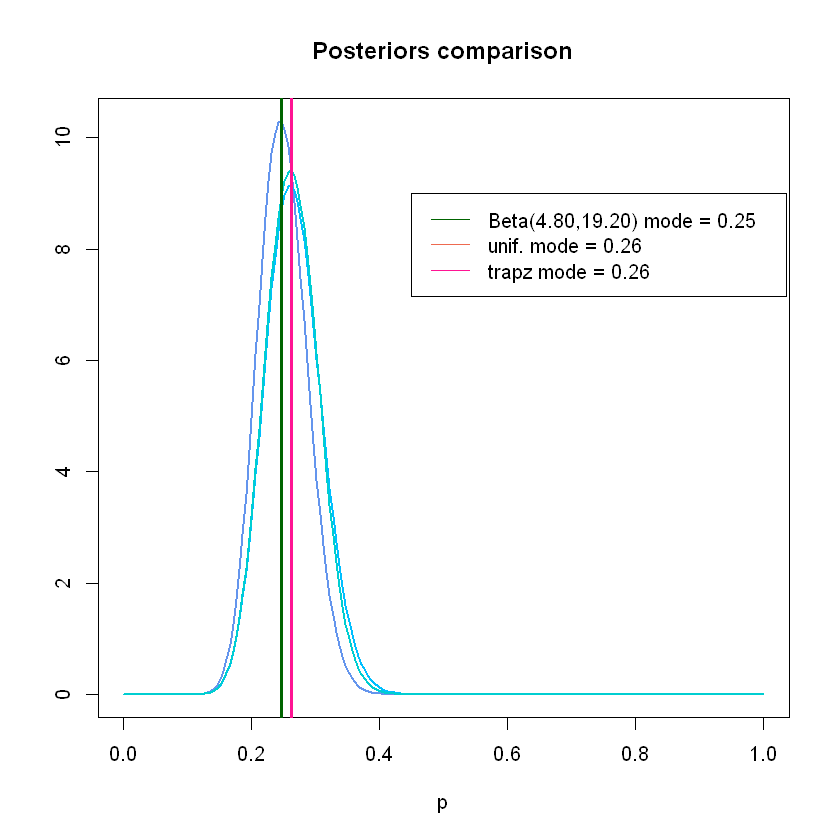

In [5]:
find.max <- function(fun, x) x[which.max(fun(x))]
# MODE COMPUTATION: Here we simply have mode = max.
mode.beta        <- find.max(posterior.beta.prior, p.vector)
mode.uniform     <- find.max(posterior.uniform.prior, p.vector)
mode.trapezoidal <- find.max(posterior.trapezoidal.prior, p.vector)

# POSTERIORS PLOTS WITH MODES HIGHLIGHTED
p.vector <- seq(0,1, length.out = 200) # p is in [0,1]
plot(p.vector, posterior.beta.prior(p.vector), type = "l", col = "cornflowerblue", lwd = 2, xlab = "p", ylab = "", main = "Posteriors comparison")
lines(p.vector, posterior.uniform.prior(p.vector), col = "deepskyblue", lwd = 2)
lines(p.vector, posterior.trapezoidal.prior(p.vector), col = "darkturquoise", lwd = 2)

abline(v = mode.beta, col = "darkgreen", lwd = 2.5); abline(v = mode.uniform, col = "coral2", lwd = 2.5); abline(v = mode.trapezoidal, col = "deeppink", lwd = 2.5)
legend(legend = c(sprintf("Beta(%.2f,%.2f) mode = %.2f",alpha,beta, mode.beta),sprintf("unif. mode = %.2f", mode.uniform),sprintf("trapz mode = %.2f", mode.trapezoidal)), col = c("darkgreen","coral2","deeppink"), lty = rep(1, times = 3), x = 0.45, y = 9)

# Ex. 2.3: most probable value, 95% credibility intervals
We already computed and plotted the most probable value as the argmax of each posterior; we found all of them yield $\approx 0.25-0.26$, in good agreement with the $26/100$ naive estimate.        
To compute the 95% credibility intervals for each posterior the simplest (albeit not particularly rigorous) approach is to estimate the appropriate integration extrema by plot inspection.

[1] "beta prior: integral between  0.161231155778894 and 0.331231155778895 = 0.972035774891732"
[1] "uniform prior: integral between  0.175306532663317 and 0.347306532663317 = 0.951976175155707"
[1] "trapezoidal prior: integral between  0.179306532663317 and 0.343306532663317 = 0.952413709373188"


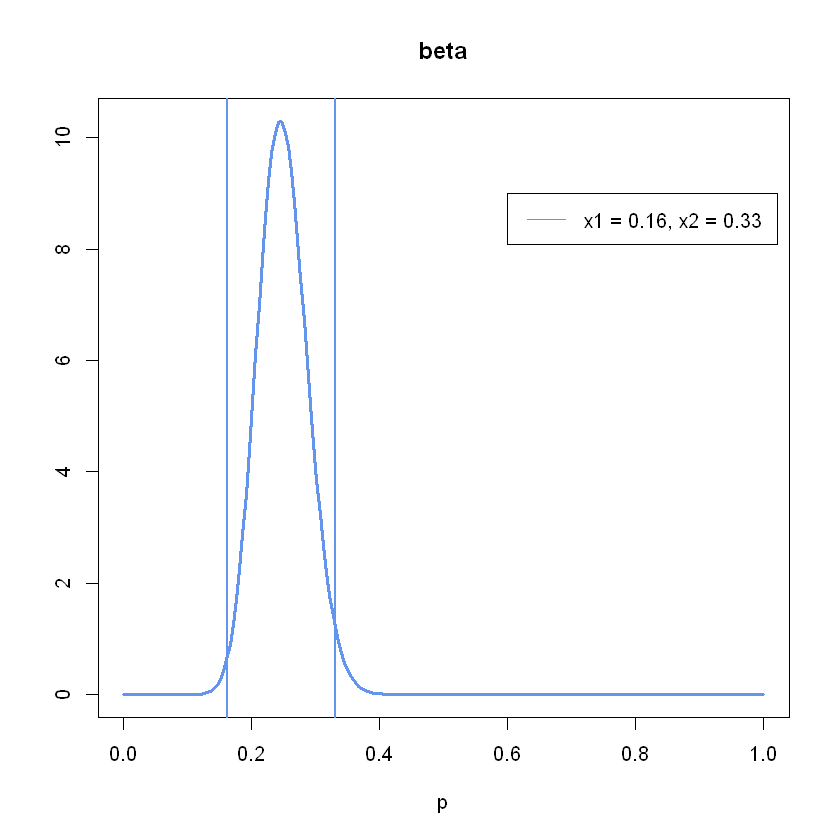

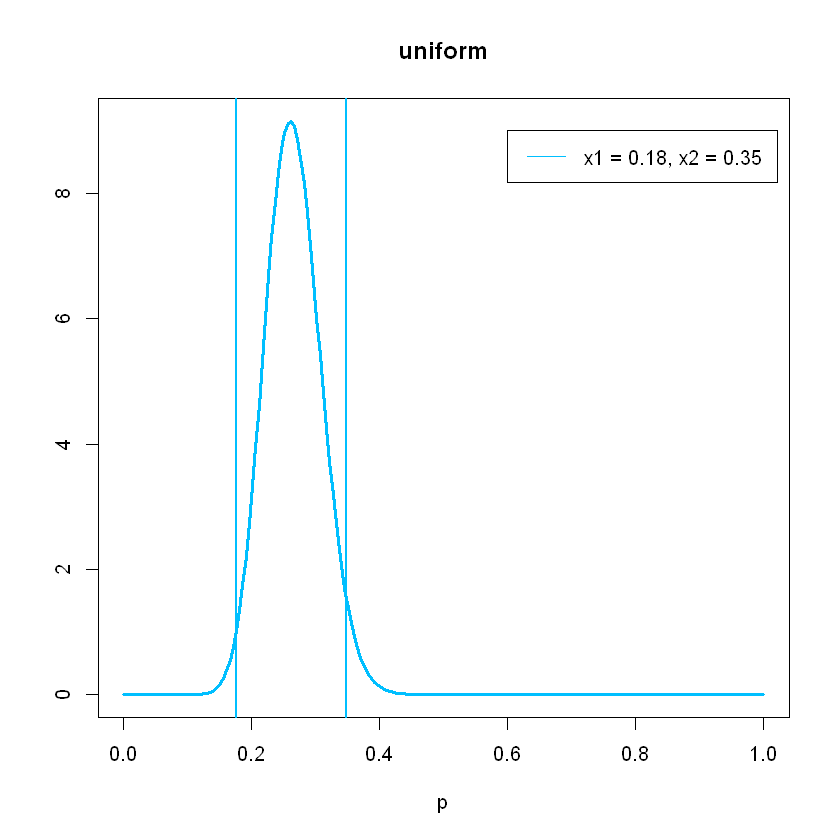

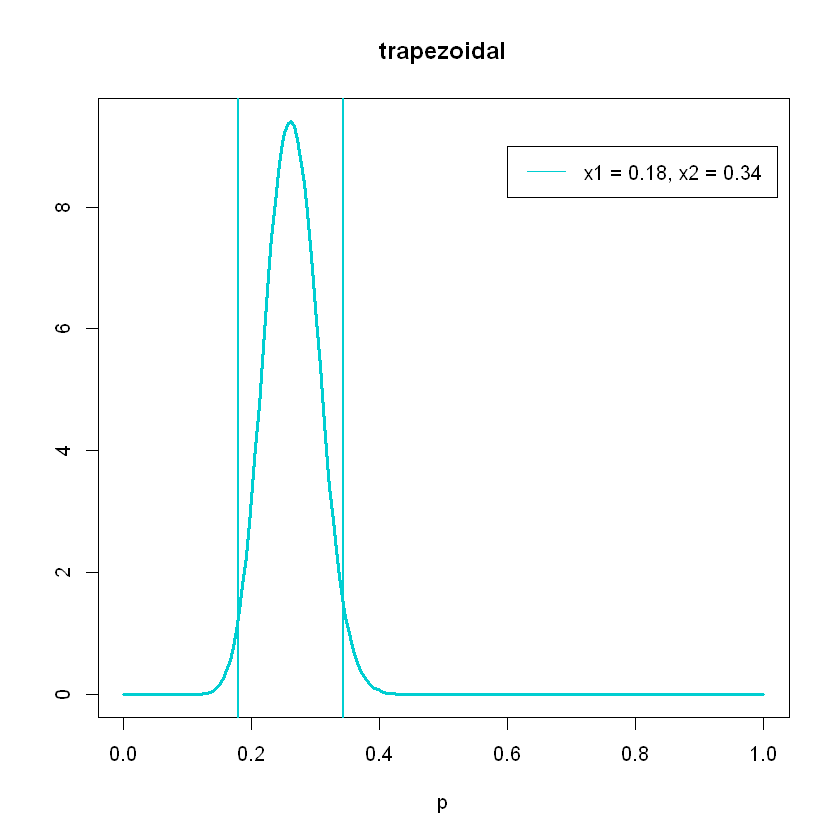

In [6]:
x1.95.beta <- mode.beta - 0.085; x2.95.beta <- mode.beta + 0.085
print(paste("beta prior: integral between ", x1.95.beta, "and", x2.95.beta, "=", integrate(posterior.beta.prior, x1.95.beta, x2.95.beta)$value))

x1.95.uniform <- mode.uniform - 0.086; x2.95.uniform <- mode.uniform + 0.086
print(paste("uniform prior: integral between ", x1.95.uniform, "and", x2.95.uniform, "=", integrate(posterior.uniform.prior, x1.95.uniform, x2.95.uniform)$value))

x1.95.trapezoidal <- mode.trapezoidal - 0.082; x2.95.trapezoidal <- mode.trapezoidal + 0.082
print(paste("trapezoidal prior: integral between ", x1.95.trapezoidal, "and", x2.95.trapezoidal, "=", integrate(posterior.trapezoidal.prior, x1.95.trapezoidal, x2.95.trapezoidal)$value))

posteriors.list <- list(posterior.beta.prior, posterior.uniform.prior, posterior.trapezoidal.prior)
colors.vec     <- c("cornflowerblue","deepskyblue","darkturquoise")
names.vec      <- c("beta","uniform","trapezoidal")
x1.vec         <- c(x1.95.beta, x1.95.uniform, x1.95.trapezoidal)
x2.vec         <- c(x2.95.beta, x2.95.uniform, x2.95.trapezoidal)

p.vector <- seq(0, 1, length.out = 200)
for (i in 1:3) {
    plot(p.vector, posteriors.list[[i]](p.vector), col = colors.vec[i], type = "l", xlab = "p", ylab = "", main = names.vec[i], lwd = 2.5)
    abline(v = x1.vec[i], col = colors.vec[i], lwd = 2); abline(v = x2.vec[i], col = colors.vec[i], lwd = 2)
    legend(legend = sprintf("x1 = %.2f, x2 = %.2f", x1.vec[i], x2.vec[i]), x = 0.6, y = 9, col = colors.vec[i], lty = 1)
}

# Exercise 3: coin flip inference
**Introduction**
A coin is flipped $n=30$ times with the following outcomes:
\begin{equation}
  \text{T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H}
\end{equation}
which I converted to an R-intelligible format using [this python script](https://github.com/marco-giunta/AdvStatPhysAn/blob/main/scripts/coin_flip.py) since I'm too lazy to do it myself.        
*Generative model*: we assume a single coin flip is a Bernoulli trial parametrized by an unknown probability $p$; if we flip the coin $n\geq 2$ times then the same holds but with a binomial distribution instead. We therefore apply Bayes' theorem to infer the value of $p \in [0,1]$ given an appropriate prior and the data seen above.            

## Ex. 3.1: likelihood, priors plots
In order to compute the posterior we apply Bayes' theorem as already done many times; the only difference is the following.    
We already showed that likelihood = binomial; exactly as in exercise 1 if prior = uniform then the posterior will equal the likelihood up to a normalization constant factor - which means the inference is trivial! We simply need to set posterior = normalized Binomial wrt p.       
What if we use a beta prior? Then since we know that the beta distribution is the conjugate prior of the binomial likelihood we obtain posterior = beta with slightly different parameters; once again no explicit computation is actually needed.

In [7]:
# With more complex priors we would define something like:

compute.posterior <- function(likelihood, prior) {
    numerator <- function(p) likelihood(p)*prior(p)
    denominator <- integrate(numerator, 0, 1)$value
    posterior <- function(p) numerator(p)/denominator
    return (posterior)
}
# and then use:
uniform.prior <- function(p) rep(1, times = length(p)) # f(p)=1 defined over [0,1] is already normalized
# and so on; with a uniform/beta priors, though, we know beforehand the analytic expression of the posterior
# hence no explicit computation is needed

In [8]:
coin.flips <- c("T", "T", "T", "T", "T", "H", "T", "T", "H", "H", "T", "T", "H", "H", "H", "T", "H", "T", "H", "T", "H", "H", "T", "H", "T", "H", "T", "H", "H", "H")
print(paste("number of heads: ", sum(coin.flips == "H")))
print(paste("number of tails: ", sum(coin.flips == "T")))
# since we have as many heads as tails over a relatively large number of samples (30) we intuitively suspect the coin is fair; we can make this more rigorous using inference

[1] "number of heads:  15"
[1] "number of tails:  15"


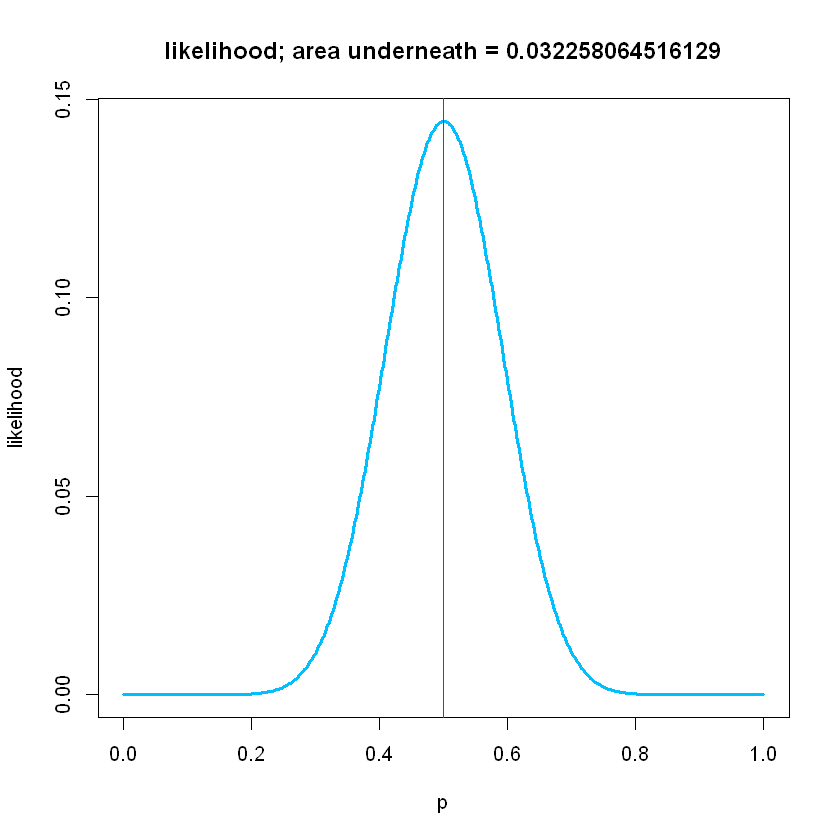

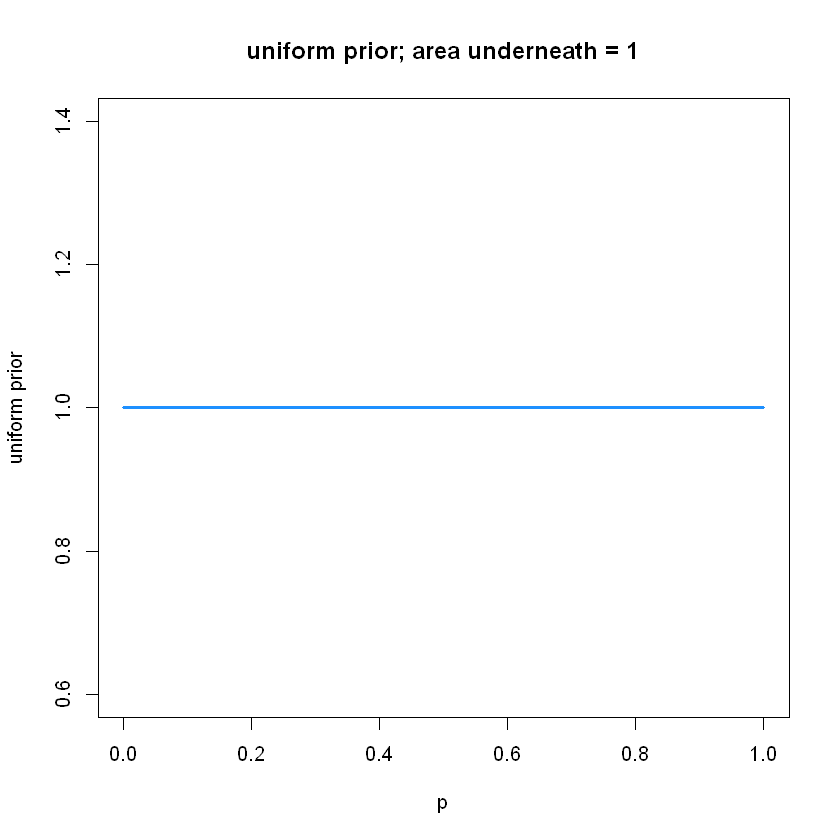

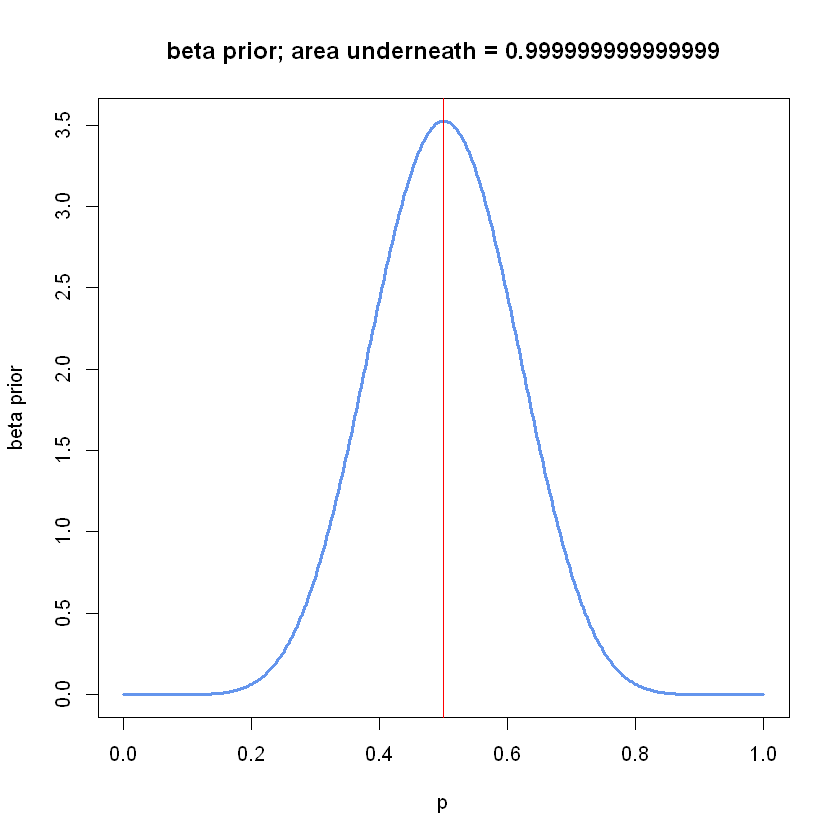

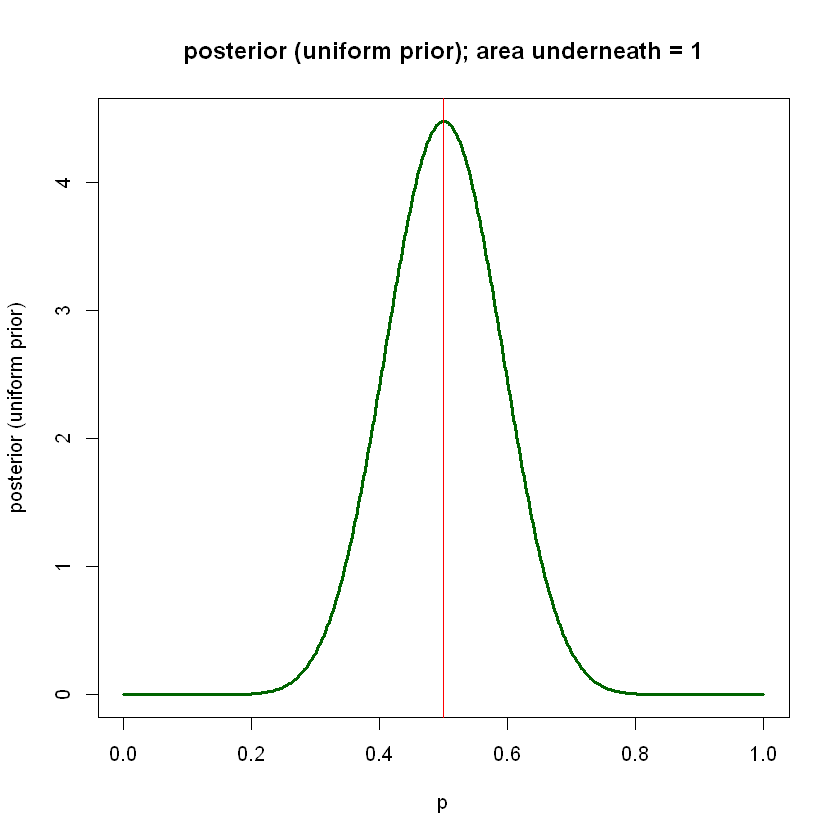

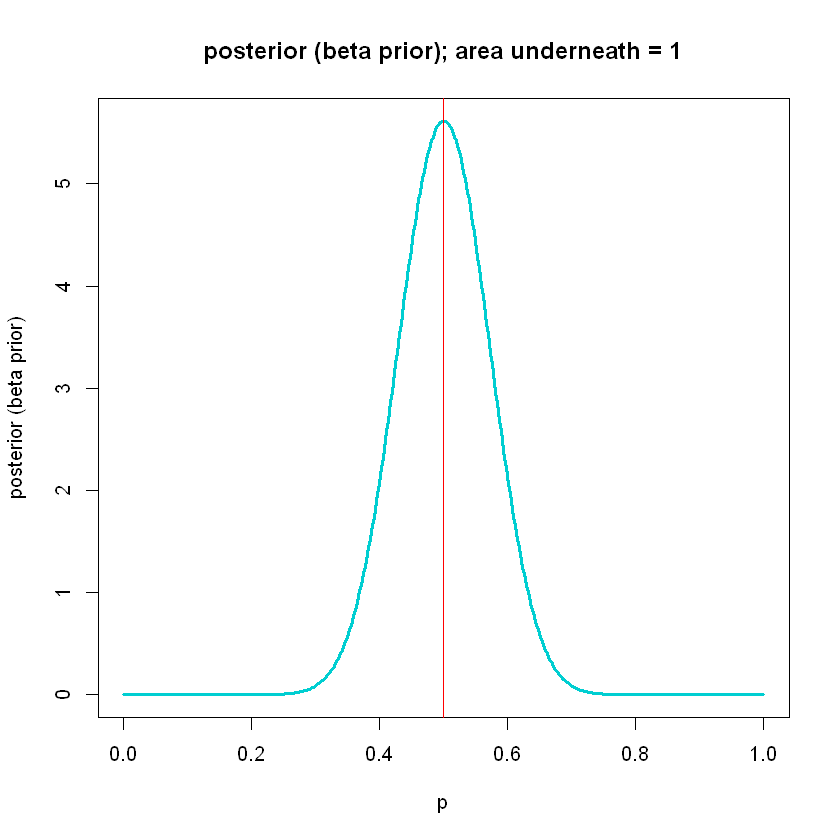

In [9]:
n.successes <- 15; n.attempts <- 30
ap <- 10; bp <- ap # these stand for "alpha of the prior" and "beta of the prior"

likelihood        <- function(p) dbinom(x = n.successes, size = n.attempts, prob = p) # let's say p is the probability of obtaining heads; then during the experiment we obtained 15/30 successes.
uniform.prior     <- function(p) rep(1, times = length(p)) # f(p)=1 defined over [0,1] is already normalized
beta.prior        <- function(p) dbeta(p, shape1 = ap, shape2 = bp) # let's say we strongly believe the coin is fair. Then we can use a narrow beta prior (large alpha) symmetrically peaked around p=0.5 (alpha=beta)
uniform.posterior <- function(p) likelihood(p)/integrate(likelihood, 0, 1)$value # binom likelihood + uniform prior --> binomial posterior normalized wrt p
beta.posterior    <- function(p) dbeta(p, shape1 = (ap + n.successes), shape2 = (bp + (n.attempts - n.successes))) # binom likelihood + beta prior --> beta posterior with alpha = old.alpha + n.suc, beta  olb.beta + n.at - n.suc

# helper plot function
plot.function <- function(x, f, color, name, separate.plot = TRUE) {
    if (separate.plot) plot(x, f(x), type = "l", lwd = 3, col = color, xlab = "p", ylab = name, main = paste0(name,"; area underneath = ",integrate(f, 0, 1)$value))
    else lines(x, f(x), type = "l", lwd = 3, col = color, xlab = "p", ylab = name, main = paste0(name,"; area underneath = ",integrate(f, 0, 1)$value))
}

p.vector <- seq(0, 1, length.out = 500)

plot.function(p.vector, likelihood, "deepskyblue", "likelihood"); abline(v = 0.5, col = "red") # it's an intuitive result: we obtained 15/30 successes and the likelihood is max. at p = 0.5
plot.function(p.vector, uniform.prior, "dodgerblue", "uniform prior")
plot.function(p.vector, beta.prior, "cornflowerblue", "beta prior"); abline(v = 0.5, col = "red")
plot.function(p.vector, uniform.posterior, "darkgreen", "posterior (uniform prior)"); abline(v = 0.5, col = "red") # same shape as the likelihood, of course. Weak prior --> the likelihood dominates (i.e. the data do)
plot.function(p.vector, beta.posterior, "darkturquoise", "posterior (beta prior)"); abline(v = 0.5, col = "red") # still peaked around 0.5: this is inevitable, since both the prior and the data are too

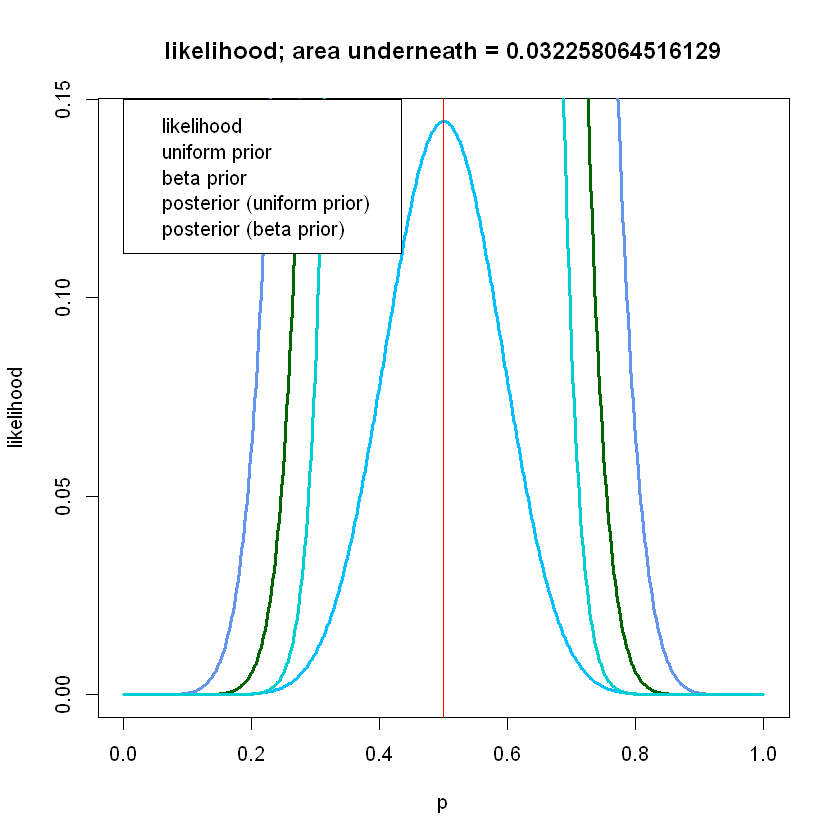

In [10]:
# we now plot all curves in the same graph to compare them
plot.function(p.vector, likelihood, "deepskyblue", "likelihood"); abline(v = 0.5, col = "red")

func.list <- list(uniform.prior, beta.prior, uniform.posterior, beta.posterior)
col.list <- list("dodgerblue", "cornflowerblue", "darkgreen", "darkturquoise")
names.list <- list("uniform prior", "beta prior", "posterior (uniform prior)", "posterior (beta prior)")

#pmap(func.list, col.list, names.list, plot.function, separate.plot = FALSE) # doesn't work, unfortunately
for (i in 1:4) plot.function(p.vector, func.list[[i]], col.list[[i]], names.list[[i]], separate.plot = FALSE)
legend(x = 0, y = 0.15, legend = c("likelihood", unlist(names.list)), col = c("deepskyblue", unlist(col.list)))

## Ex. 3.2: 95% credibility interval estimate
A possible way to proceed is the gaussian approximation as an estimate for the two values $a, b$ such that $\int_a^b \text{posterior} = \text{desired value}$: this means computing the gaussian with the same mean and std. dev. as our posterior, and integrating *that distribution* in place of the actual posterior - which is easier, since we know already that $95\%$  of a gaussian's area is in $[\mu-2\sigma, \mu+2\sigma]$.         
A simpler/lazier approach is to simply inspect the plot and "guess" which integration extrema to use.

In [11]:
compute.sigma.from.beta.dist <- function(alpha, beta, r, n) 1/(alpha + beta + n - 2)*sqrt((alpha + r - 1)/(alpha + r))

sigma.beta.prior <- compute.sigma.from.beta.dist(alpha = ap, beta = bp, r = n.successes, n = n.attempts)
print(sigma.beta.prior)
k <- 7
integrate(beta.posterior, (0.5-k*sigma.beta.prior), (0.5+k*sigma.beta.prior))$value

[1] 0.02041241


[1] 0.9599948

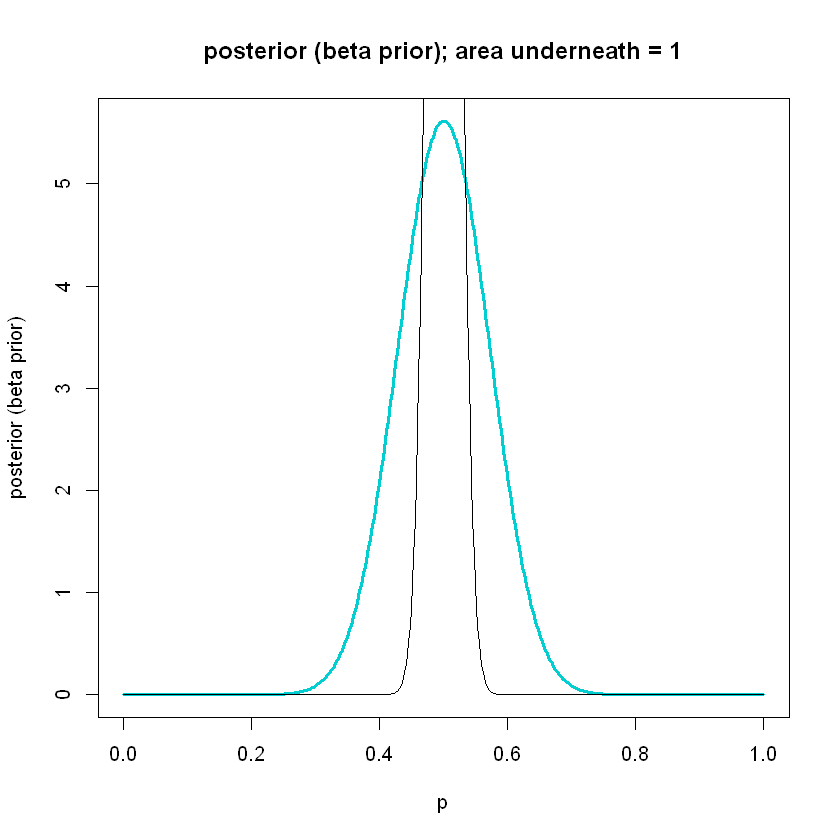

In [12]:
plot.function(p.vector, beta.posterior, "darkturquoise", "posterior (beta prior)")
lines(p.vector, dnorm(p.vector, mean = 0.5, sd = sigma.beta.prior)) # the gaussian approximation clearly doesn't work for our purposes

[1] "integral between  0.36 and 0.64 = 0.955615155284447"
[1] "integral between  0.2 and 0.8 = 0.9999974127351"
[1] "integral between  0.425 and 0.574 = 0.708212301526372"


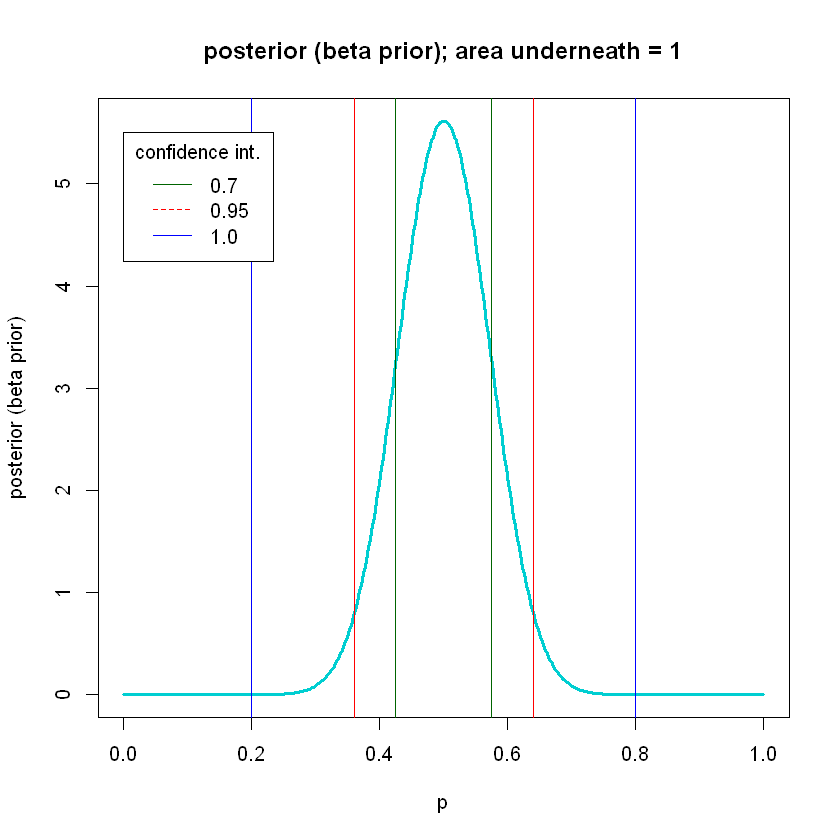

In [13]:
x1.95 <- 0.36; x2.95 <- 0.64
print(paste("integral between ", x1.95, "and", x2.95, "=", integrate(beta.posterior, x1.95, x2.95)$value))

x1.100 <- 0.2; x2.100 <- 0.8
print(paste("integral between ", x1.100, "and", x2.100, "=", integrate(beta.posterior, x1.100, x2.100)$value))

x1.70 <- 0.425; x2.70 <- 0.574
print(paste("integral between ", x1.70, "and", x2.70, "=", integrate(beta.posterior, x1.70, x2.70)$value))

plot.function(p.vector, beta.posterior, "darkturquoise", "posterior (beta prior)")
abline(v = x1.70, col = "darkgreen"); abline(v = x2.70, col = "darkgreen")
abline(v = x1.95, col = "red"); abline(v = x2.95, col = "red")
abline(v = x1.100, col = "blue"); abline(v = x2.100, col = "blue")

legend(x = 0, y = 5.5, legend = c("0.7", "0.95", "1.0"), col = c("darkgreen", "red", "blue"), lty=1:2, title = "confidence int.")

## Ex. 3.3: sequential inference
To perform a sequential version of the same experiment is equivalent to reproducing the "six boxes toy model" experiment; this means that every time we perform a coin toss we update the prior instead of doing a single prior->posterior "jump" at the end of the 30 coin tosses.     
We therefore setup an iterative procedure, where the posterior computed at step $n$ becomes $n+1$'s prior; once again we exploit the fact that with a uniform/beta prior explicit applications of Bayes' theorem can be avoided - which means it suffices to have an "alpha history" and a "beta history" vector to keep track of the gradual inference.     
Notice that this time we technically need to use a Bernoulli likelihood (single coin toss), but this is not an issue since Bernoulli = Binomial with $n=1$ and $r=0 \ \text{or} \ 1$.

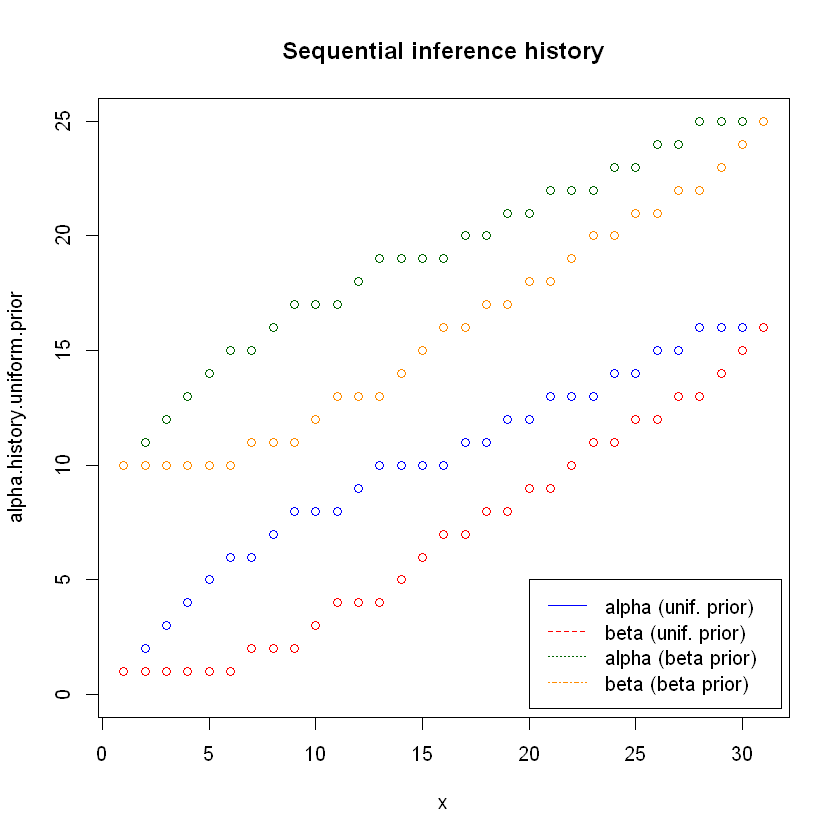

In [14]:
# SETUP:
coin.flips <- c("T", "T", "T", "T", "T", "H", "T", "T", "H", "H", "T", "T", "H", "H", "H", "T", "H", "T", "H", "T", "H", "H", "T", "H", "T", "H", "T", "H", "H", "H")
n.flips <- length(coin.flips)

# First we convert the previous array to a numeric format for convenience. Let's adopt the convention where tails = success = 1 and heads = failure = 0. This conversion is useful because if we want to infer the prob. of
# obtaining e.g. tails then having coin.flips.num[i] equal to 1 means that at step i we had a success --> the i-th Bernoulli trial was successful; hence we can use coin.flips.num[i] itself as one of the arguments of the likelihood
coin.flips.num <- rep(0, times = n.flips); coin.flips.num[coin.flips == "T"] <- 1
#print("original vs numerical version of the experimental results (T = 1, H = 0):"); print(coin.flips); print(coin.flips.num)

# PRIORS:
# We do 2 inferences, one for each prior (beta vs uniform priors, exactly as in the non sequential analysis)
alpha.history.uniform.prior <- rep(NA, times = (n.flips + 1)); beta.history.uniform.prior <- alpha.history.uniform.prior # copy-on-modify -> no need to worry about views vs copies like in e.g. python
alpha.history.beta.prior <- alpha.history.uniform.prior; beta.history.beta.prior <- beta.history.uniform.prior

# uniform prior -> alpha[1] = 1, beta[1] = 1
alpha.history.uniform.prior[1] <- 1; beta.history.uniform.prior[1] <- 1
# beta prior used in the prev. ex. -> alpha[1] = 10, beta[1] = 10
alpha.history.beta.prior[1] <- 10; beta.history.beta.prior[1] <- 10

# INFERENCE:
# The only thing we need is the following result:
# binom likelihood + beta prior --> beta posterior with alpha = old.alpha + n.suc, beta  olb.beta + n.at - n.suc
# Notice this also applies to a uniform prior since beta(1,1) = uniform distribution
for (i in 1:n.flips) { # This could probably vectorized but a) a for is easier and b) it conceptually reproduces our gradual posterior update
    # this is flip n. i. The LHS is shifted forwards due to the first element actually being the prior --> not having anything to do with any actual coin flip
    alpha.history.uniform.prior[i+1] <- alpha.history.uniform.prior[i] + coin.flips.num[i]
    alpha.history.beta.prior[i+1]    <- alpha.history.beta.prior[i] + coin.flips.num[i]
    # --------------------------------------------------------------------------------------
    beta.history.uniform.prior[i+1]  <- beta.history.uniform.prior[i] + 1 - coin.flips.num[i]
    beta.history.beta.prior[i+1]     <- beta.history.beta.prior[i] + 1 - coin.flips.num[i]
}

ymax <- max(c(alpha.history.beta.prior, alpha.history.uniform.prior, beta.history.beta.prior, beta.history.uniform.prior))
x <- 1:(n.flips + 1)

plot(x, alpha.history.uniform.prior, col = "blue", ylim = c(0, ymax)); points(x, beta.history.uniform.prior, col = "red") 
points(x, alpha.history.beta.prior, col = "darkgreen"); points(x, beta.history.beta.prior, col = "darkorange") 
legend(legend = c("alpha (unif. prior)", "beta (unif. prior)", "alpha (beta prior)", "beta (beta prior)"), col = c("blue", "red", "darkgreen", "darkorange"), x = 20, y = 5, lty = 1:4)
title(main = "Sequential inference history")

Greater and greater values of alpha and beta imply our posterior gets narrower and narrower around our most likely $p$, so the increasing vectors we obtained mean that the inference is indeed working.    
Let's now plot the actual posteriors.

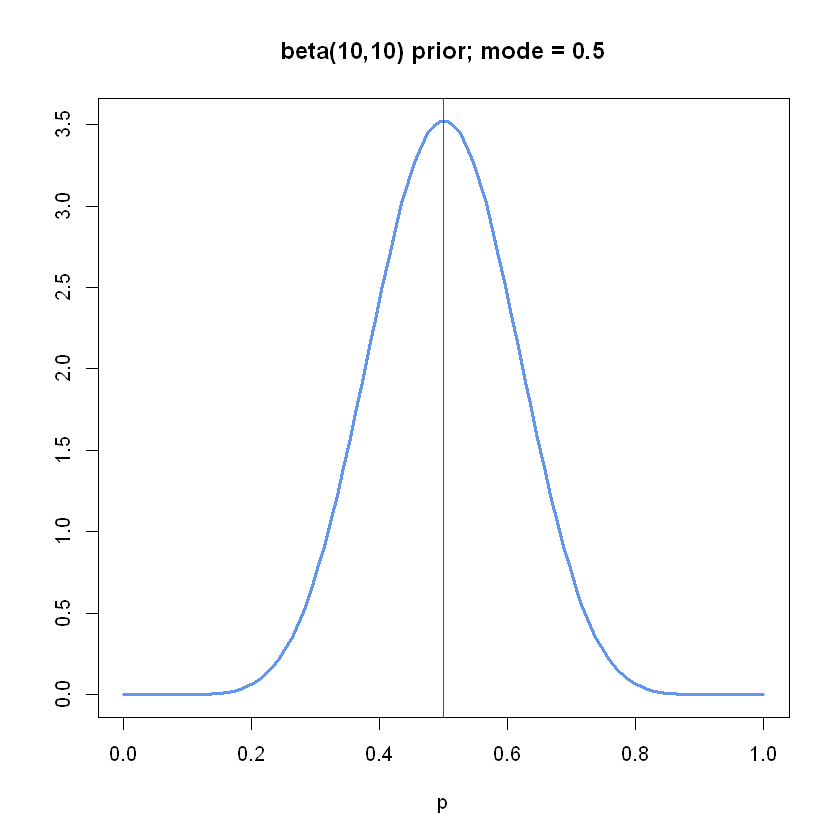

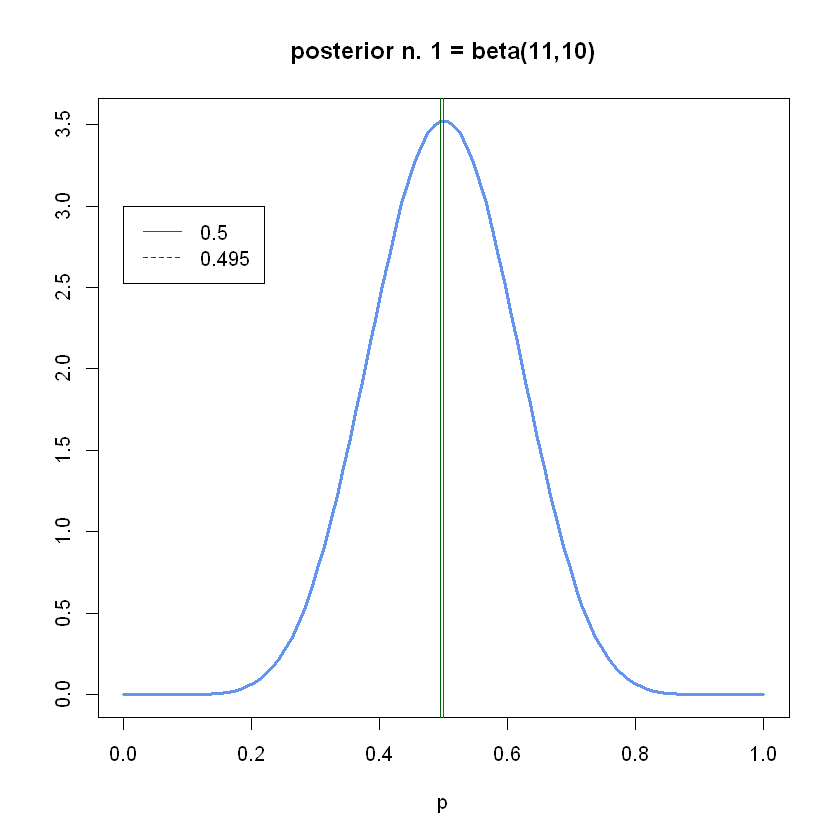

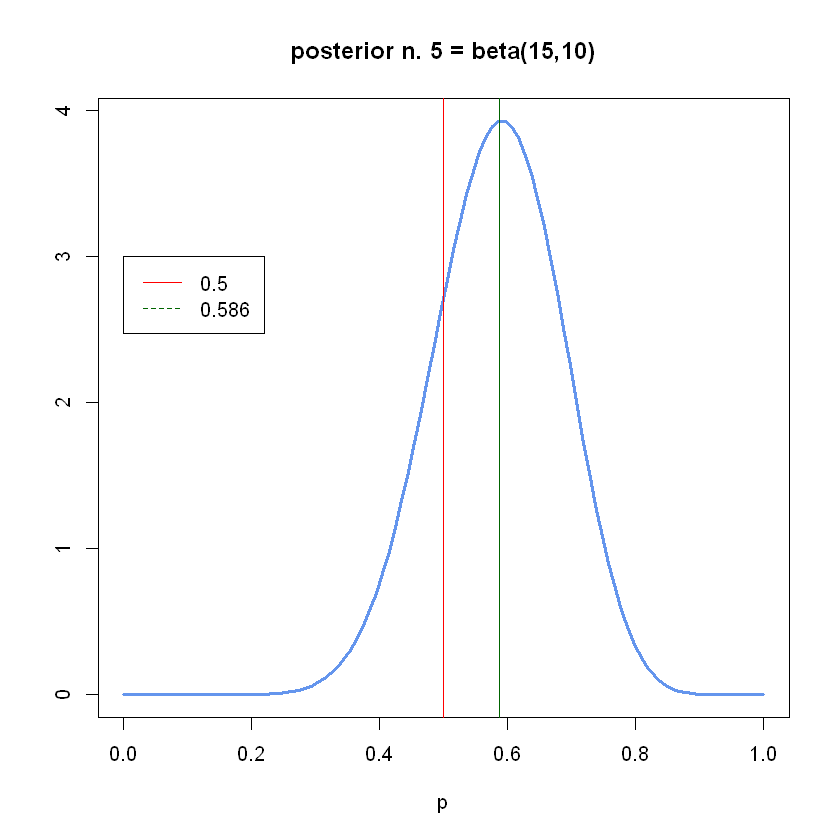

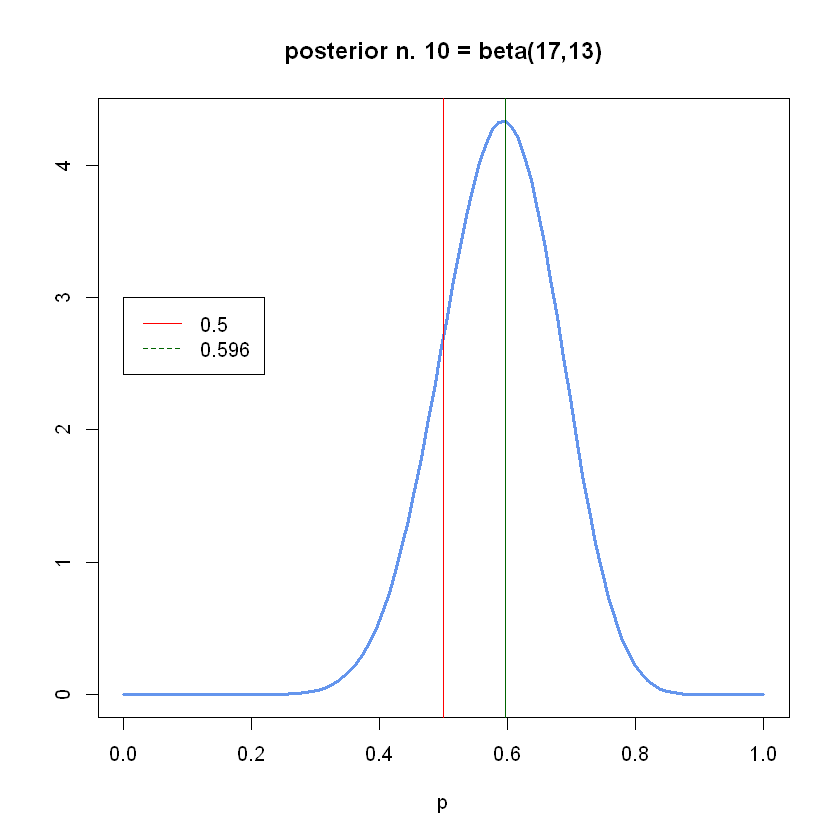

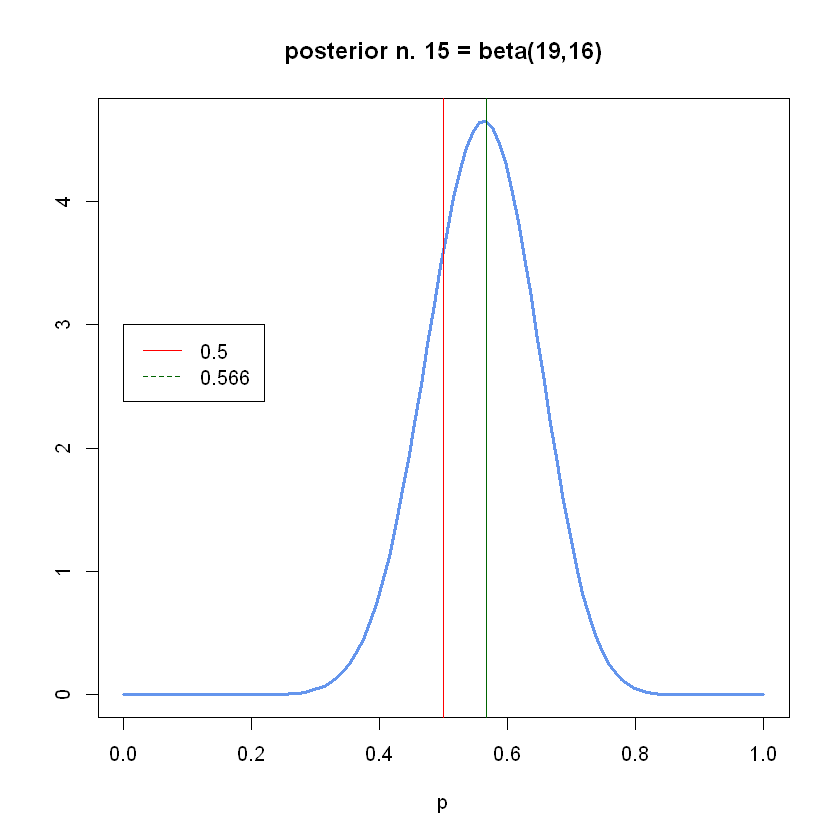

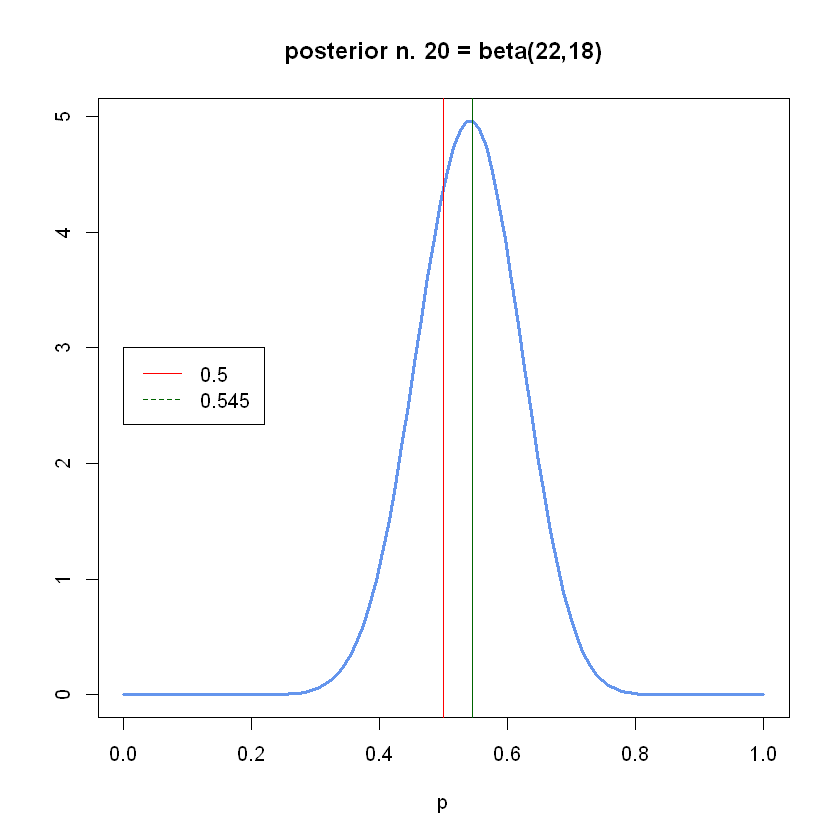

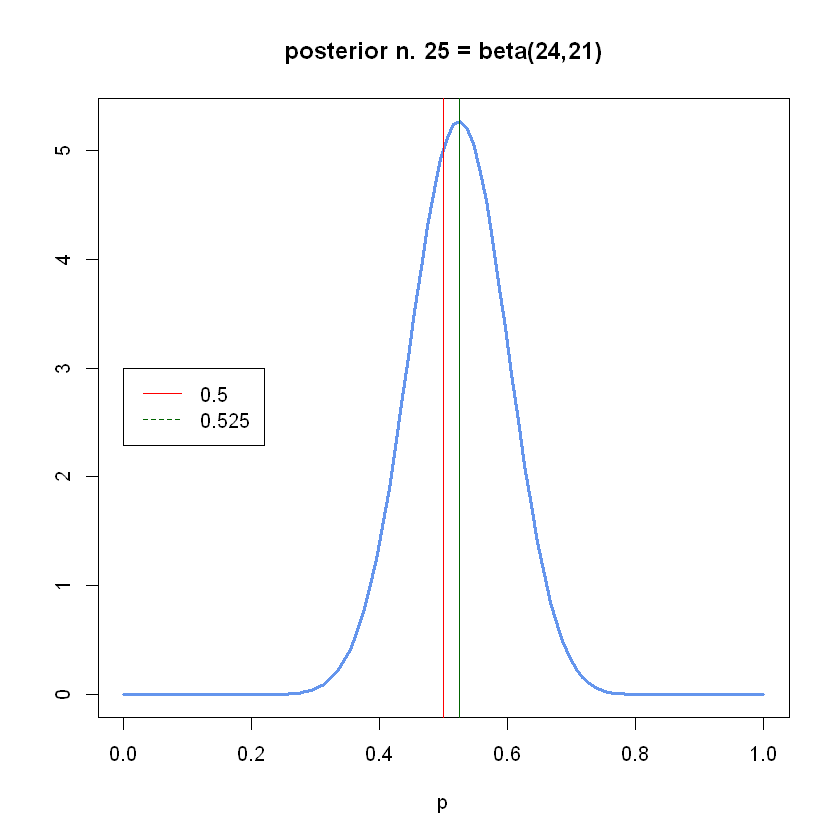

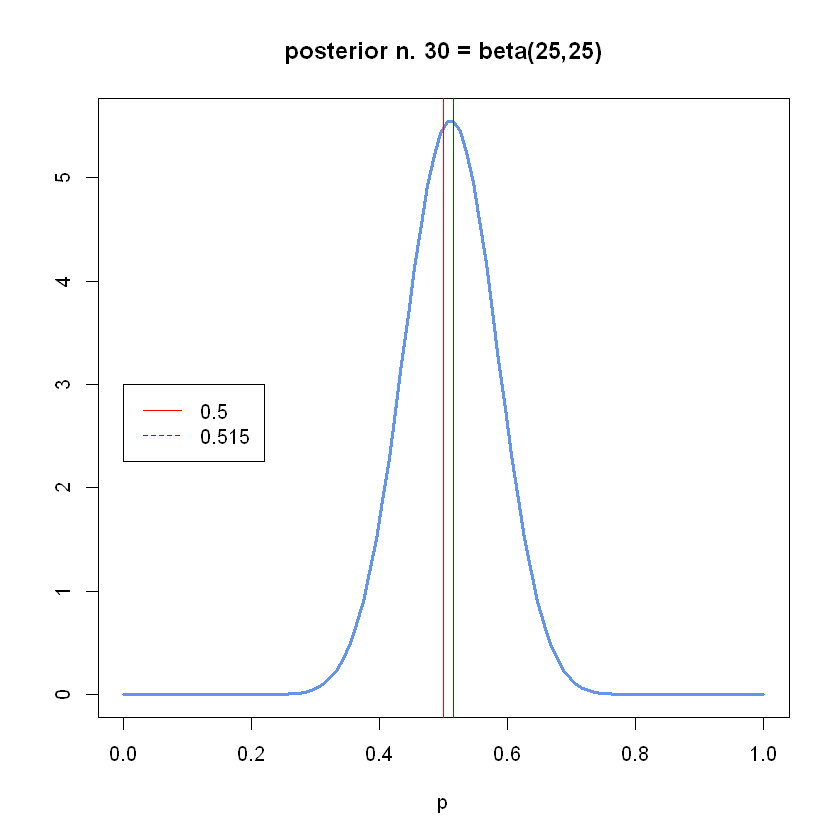

In [15]:
# BETA PRIOR 
p.vector <- seq(0, 1, length.out = 100)
#plot.function(p.vector, function(x) dbeta(x, shape1 = 10, shape2 = 10), "cornflowerblue", "beta prior"); abline(v = 0.5, col = "red")

# prior
plot(p.vector, dbeta(p.vector, shape1 = alpha.history.beta.prior[1], shape2 = beta.history.beta.prior[1]), type = "l", lwd = 3, col = "cornflowerblue", xlab = "p", ylab = "", main = "beta(10,10) prior; mode = 0.5"); abline(v = 0.5, col = "red")
# doing all of them and/or with points instead of plot is too messy
timesteps.to.plot <- c(1,(1:6)*5)
for (i in timesteps.to.plot) {
    y <- dbeta(p.vector, shape1 = alpha.history.beta.prior[i], shape2 = beta.history.beta.prior[i])
    plot(p.vector, y, type = "l", lwd = 3, col = "cornflowerblue", xlab = "p", ylab = "", main = sprintf("posterior n. %d = beta(%d,%d)", i, alpha.history.beta.prior[i+1], beta.history.beta.prior[i+1]))
    mode <- p.vector[which.max(y)]
    mode.rounded <- round(mode, digits = 3)
    abline(v = 0.5, col = "red"); abline(v = mode.rounded, col = "darkgreen")
    legend(legend = c("0.5",as.character(mode.rounded)), col = c("red", "darkgreen"), lty = 1:2, x = 0, y = 3)
}

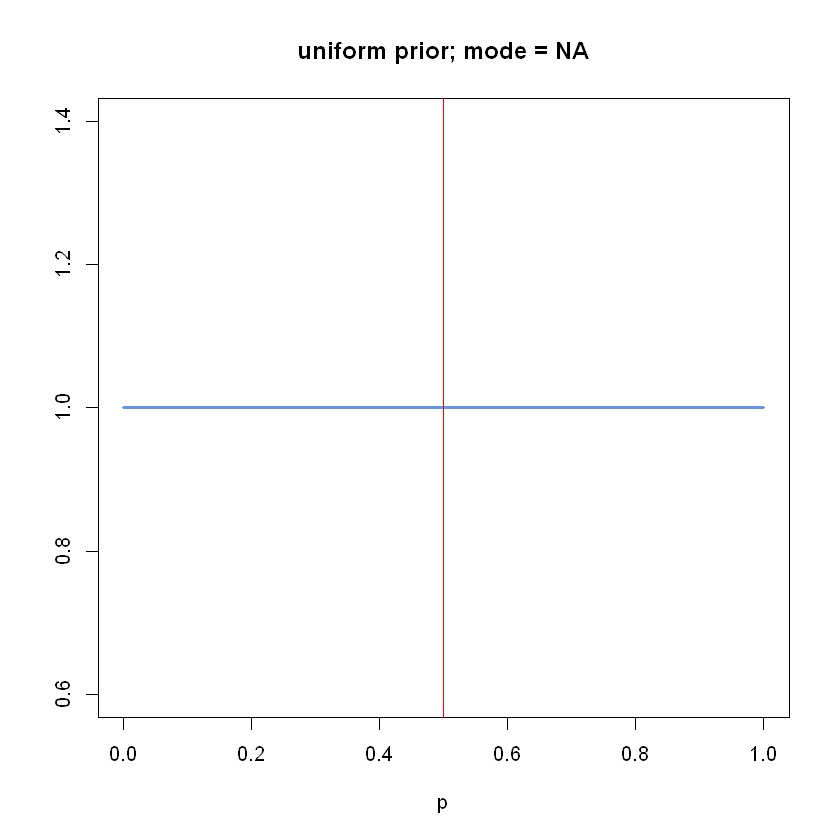

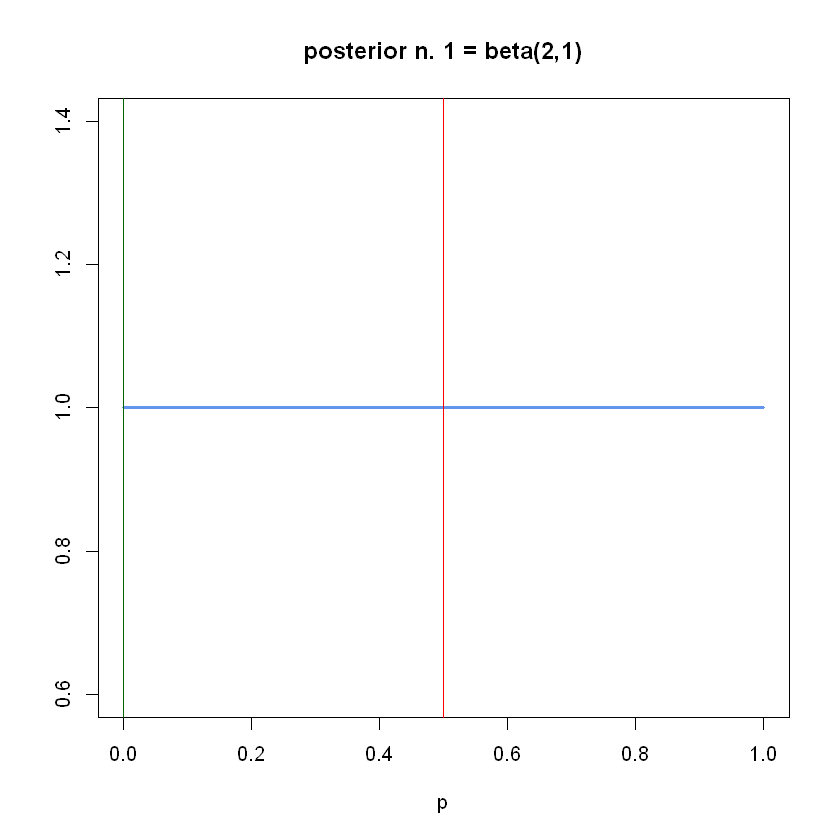

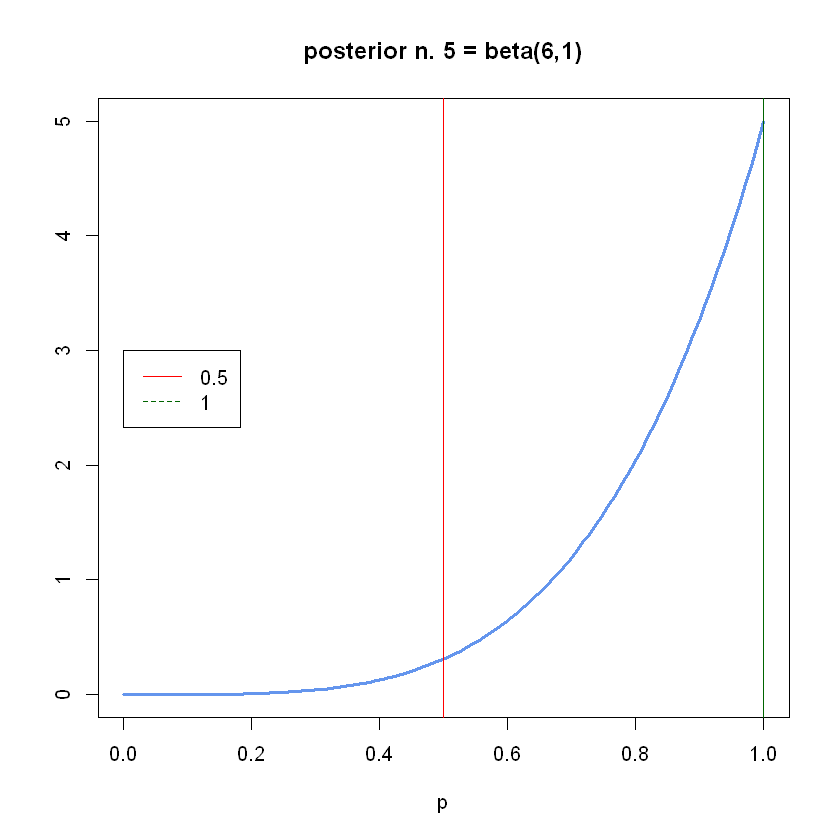

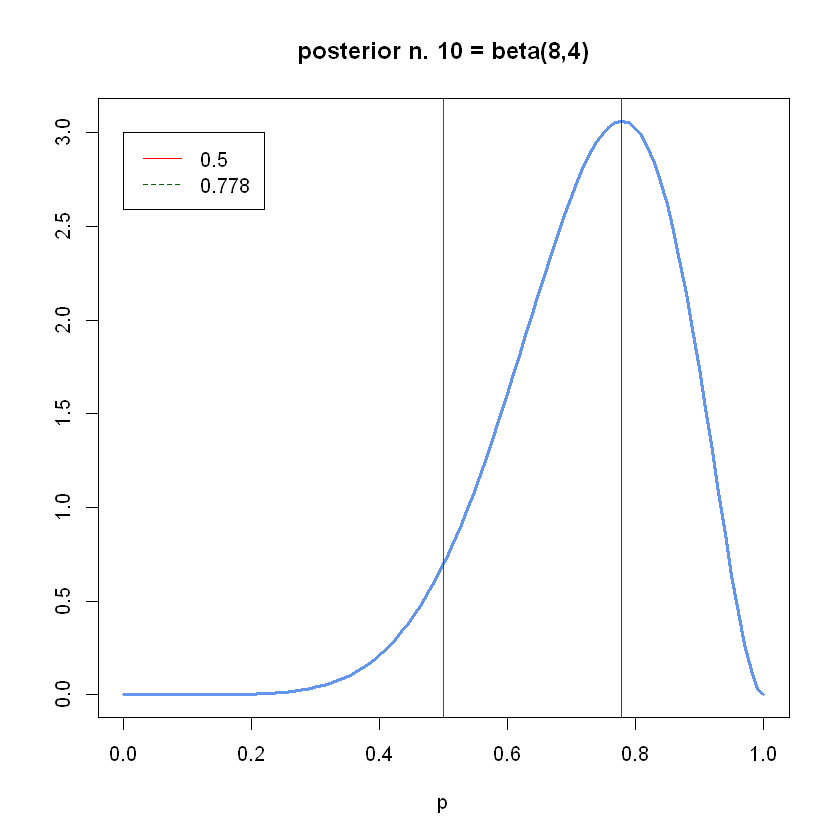

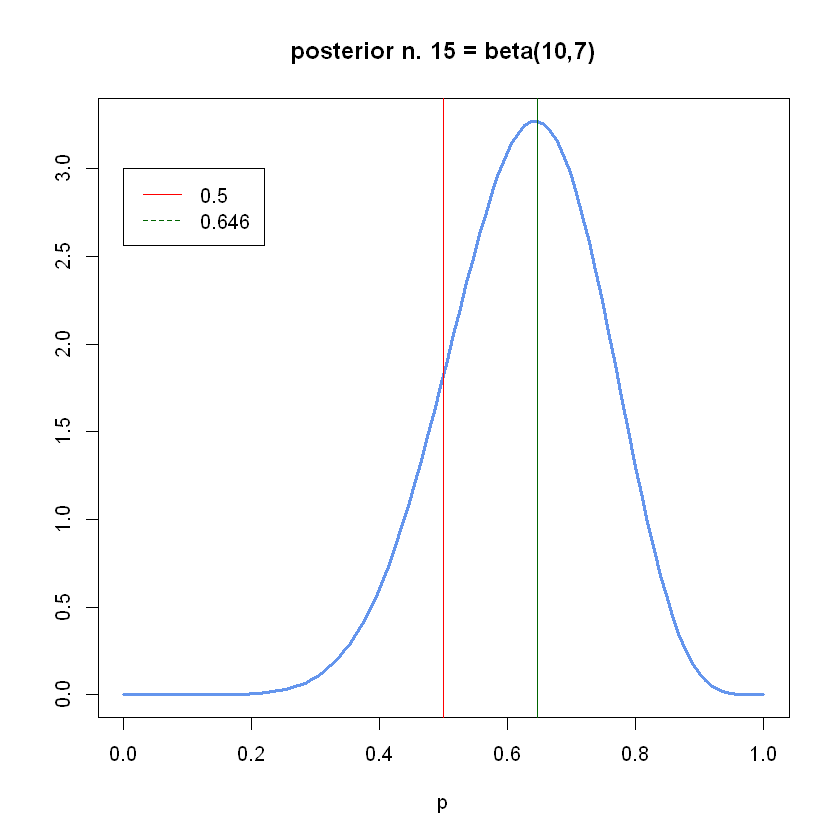

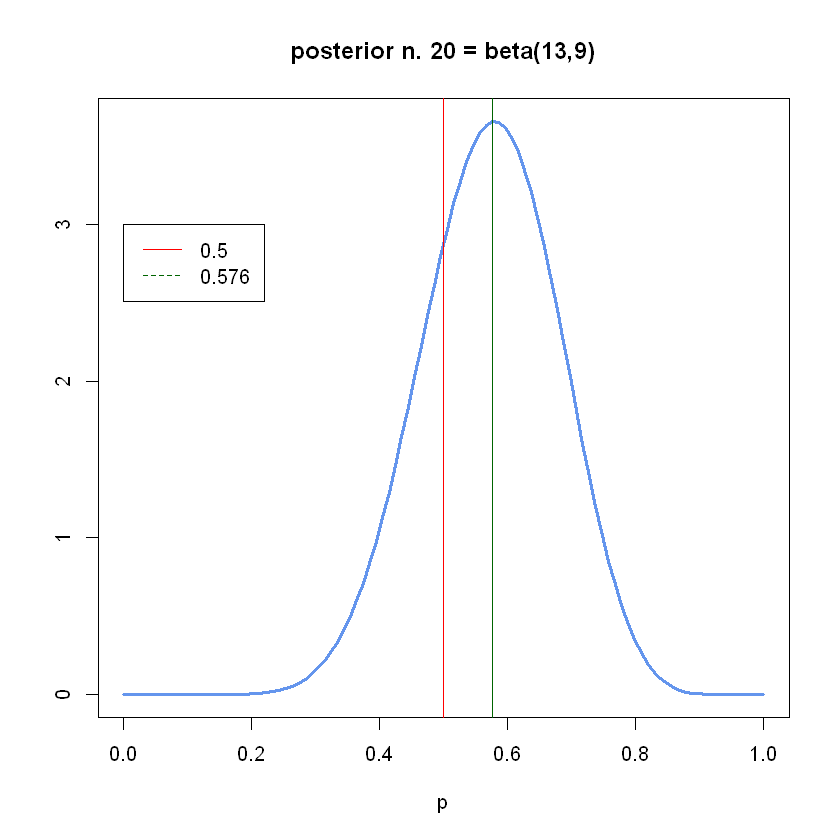

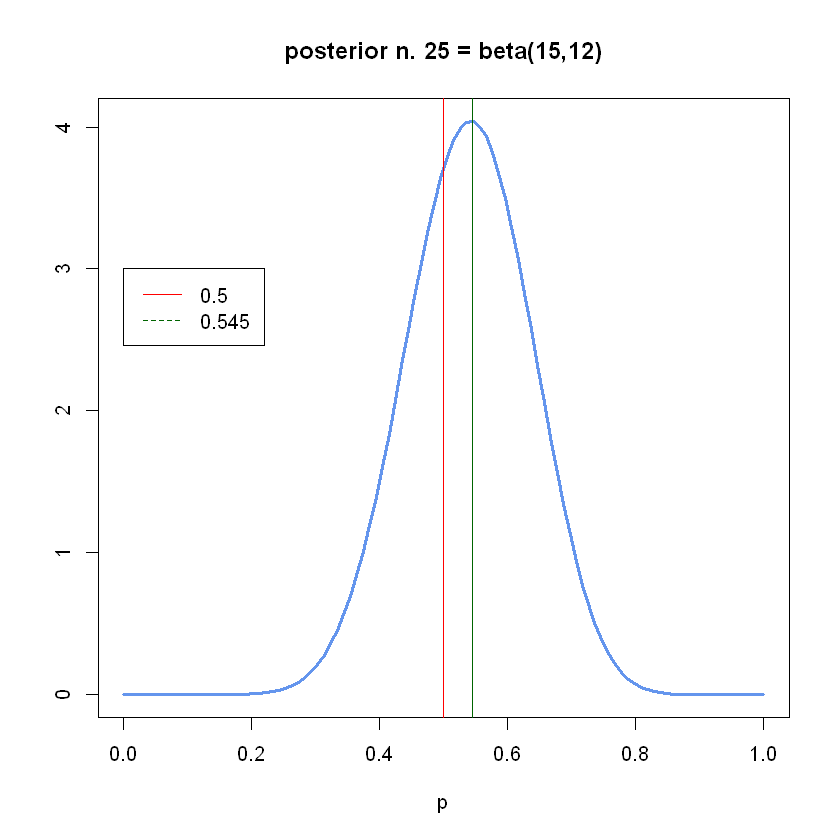

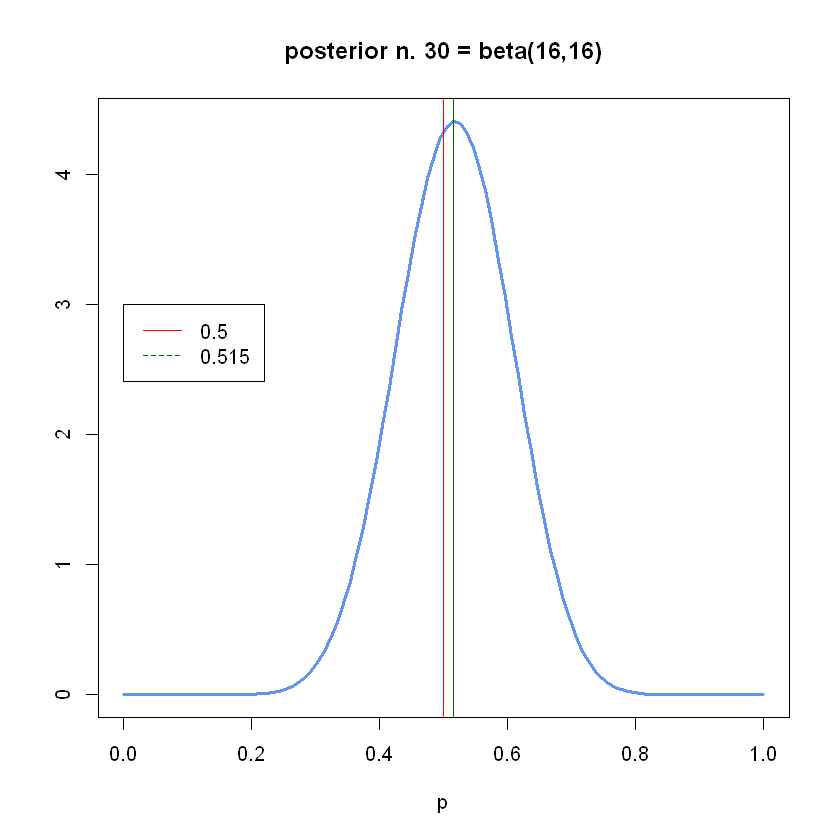

In [16]:
# UNIFORM PRIOR 
p.vector <- seq(0, 1, length.out = 100)

# prior
plot(p.vector, dbeta(p.vector, shape1 = alpha.history.uniform.prior[1], shape2 = beta.history.uniform.prior[1]), type = "l", lwd = 3, col = "cornflowerblue", xlab = "p", ylab = "", main = "uniform prior; mode = NA")
abline(v = 0.5, col = "red")

# (some) posteriors
timesteps.to.plot <- c(1,(1:6)*5)
for (i in timesteps.to.plot) {
    y <- dbeta(p.vector, shape1 = alpha.history.uniform.prior[i], shape2 = beta.history.uniform.prior[i])
    plot(p.vector, y, type = "l", lwd = 3, col = "cornflowerblue", xlab = "p", ylab = "", main = sprintf("posterior n. %d = beta(%d,%d)", i, alpha.history.uniform.prior[i+1], beta.history.uniform.prior[i+1]))
    mode <- p.vector[which.max(y)]
    mode.rounded <- round(mode, digits = 3)
    abline(v = 0.5, col = "red"); abline(v = mode.rounded, col = "darkgreen")
    legend(legend = c("0.5",as.character(mode.rounded)), col = c("red", "darkgreen"), lty = 1:2, x = 0, y = 3)
}

## Ex. 3.4: sequential vs one-step inference
There are at least 3 ways to show that as far as each element of the dataset is sampled independently of the others the result of the inference is the same whether we proceed sequentially or in just one big step:
- the empirical way;
- the theoretical but not general way;
- the fully general theoretical way.      

*Method 1: Empirical approach*      
We already performed both kinds of inferences; in both cases the final posterior is a beta distribution (given the binomial/Bernoulli likelihood and the beta/uniform prior), which means that in order to compare the posteriors we simply need to compare the values of their alpha/beta's.     
*Beta prior:* In the one step inference we simply have that the posterior's parameters are:
\begin{equation}
  \alpha' = \alpha + r, \ \beta' = \beta + n - r 
\end{equation}
whereas for the "gradual" inference $\alpha', \beta'$ can be obtained by looking at the tail of the history vectors.        
*Uniform prior:* For the one step inference the posterior is proportional to the likelihood, which is a binomial:
\begin{equation}
  \text{posterior} \propto p^r (1-p)^{n-r}
\end{equation}
This is actually a beta distribution with $\alpha'=1+r, \ \beta'=1+n-r$; once again these two values are easily compared with the tail of the history vectors.        
Notice that *this is actually exactly the same formula as before!* Indeed $U[0,1] = \text{Beta}(\alpha_0=1,\beta_0=1)$ - which means the previous equations for $\alpha', \beta'$ still hold. Due to this fact separately verifying everything works for both the beta and the uniform prior is technically superfluous, but we do it anyway because it's simple.

In [17]:
ap <- 10; bp <- 10
n.successes <- 15; n.attempts <- 30
# alpha non seq: 10+15=25, beta non seq: 10+30-15=25
print("Beta prior:")
print(sprintf("alpha one step = %d, alpha sequential = %d", (ap+n.successes), tail(alpha.history.beta.prior, 1)))
print(sprintf("beta one step = %d, beta sequential = %d", (bp+n.attempts-n.successes), tail(beta.history.beta.prior, 1))) # alpha = beta --> sym.

print("Uniform prior:")
print(sprintf("alpha one step = %d, alpha sequential = %d", (1+n.successes), tail(alpha.history.uniform.prior, 1)))
print(sprintf("beta one step = %d, beta sequential = %d", (1+n.attempts-n.successes), tail(beta.history.uniform.prior, 1))) 

# all values match!

[1] "Beta prior:"
[1] "alpha one step = 25, alpha sequential = 25"
[1] "beta one step = 25, beta sequential = 25"
[1] "Uniform prior:"
[1] "alpha one step = 16, alpha sequential = 16"
[1] "beta one step = 16, beta sequential = 16"


*Method 2: Theoretical but not fully general approach*              
We already know that in the one step approach the likelihood is a binomial and the final posterior is a beta with $\alpha' = \alpha + r, \ \beta' = \beta + n - r$; let's show the same posterior can be reached with the sequential inference.               
In this second case we have that likelihood = Bernoulli, i.e.
\begin{equation}
  \text{likelihood for a single step} \propto p^{r_0} (1-p)^{1-r_0} = \left\{
  \begin{array}
    \ p \qquad \text{if} \ r_1 = 1\\
    \ 1-p \ \text{if} \ r_1 = 0
  \end{array}\right.
\end{equation}
where $r_1$ is the number of successes for a single trial, i.e. 1 if the trial is successful and 0 otherwise.    
If we now perform $n$ *independent* Bernoulli trials and consider the case with $r$ successes and $n-r$ fails we have:
\begin{equation}
  \text{many steps likelihood} \propto \prod_{i=1}^r p \prod_{i=1}^{n-r} (1-p) = p^r (1-p)^{n-r}
\end{equation}
which is *exactly the same likelihood as in the one step inference* (up to an irrelevant factor, which is absorbed by the overall normalization constant)*!*    
If we choose the same prior for both inferences, then, it's inevitable that we obtain the same posterior. Notice how crucial the independence assumption was to obtain this result: not only the above equation wouldn't have held otherwise, but if, say, each sampling perturbed the system then of course performing the experiment in two different "styles" would alter the result.

*Method 3: fully general theoretical approach*                 
Let's say an inference is performed with two different datasets, $D_1$ and $D_2$; we can imagine that these are two parts of the same datasets which have been separated for convenience, or maybe that they have been collected somme time apart. What happens if we first do the inference with $D_1$ and $D_2$ together, then repeat it with $D_1$ first, $D_2$ later? (We assume we're trying to infer $\theta =$ set of parameters of some model)        

*$D_1$ and $D_2$ as a unique dataset:* Bayes' theorem becomes:
\begin{equation}
  P(\theta| D_1 D_2) = \frac{P(D_1 D_2 | \theta)P(\theta)}{P(D_1 D_2)}
\end{equation}
*Separated datasets*: the first application of Bayes' theorem is:
\begin{equation}
  P(\theta | D_1) = \frac{P(D_1|\theta)P(\theta)}{P(D_1)}
\end{equation}
Second application (the above posterior becomes below's prior):
\begin{equation}
  P(\theta|D_2) = \frac{P(D_2|\theta)P(\theta| D_1)}{P(D_2)} = \frac{P(D_2|\theta)P(D_1|\theta)P(\theta)}{P(D_1)P(D_2)}
\end{equation}
If $D_1, D_2$ are independent we have:
\begin{equation}
  P(D_1|\theta) P(D_2|\theta) = P(D_1 D_2|\theta), \quad P(D_1)P(D_2) = P(D_1 D_2)
\end{equation}
which means our inference becomes:
\begin{equation}
  P(\theta| D_1 D_2) = \frac{P(D_1 D_2 | \theta)P(\theta)}{P(D_1 D_2)}
\end{equation}
*which is exactly the equation we write in the case of a one step inference!*     
Once again we stress how critical independence was, both in a technical and a conceptual sense.